In [ ]:
"""
File Created: 2023-12-06
Author: Patrick G. Cho
Contact: pcho@nd.edu
Purpose: Grid-Cell Wise Analysis of d18O_P on different timescales

Details:
This script is designed to illustrate the spatio-temporal relationship between the IWC and PWC metrics and the d18O_P fields in ECHAM5-wiso. The analysis encompasses various timescales the east African Short Rains (October, November, December), as well as Annual, Three-Year, and Five-Year intervals. Additionally, we employ multiple regression to analyze the extent to which the Walker Circulation influences water isotopes on different timescales. The script achieves this by downsampling the time series data into the specified intervals. The study period spans from 1958 to 2013. 

In summary, this notebook will produce the foundational figures for Figure 2. This code can also be used to recreate Figure S3. 
"""

# Load Packages

In [1]:
# Data Management
import pandas as pd
import xarray as xr
import dask.array as dask
import cftime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Correlation Analysis
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm

# Calculations
from amount_weighted_ann_mean import amount_weighted_ann_mean
from weighted_temporal_mean import weighted_temporal_mean
from spatial_corr import compute_correlations

# Image Resolution on MacOS
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Clean Data

In [2]:
path = 'YourFilePath'
path2 = 'YourFilePath2'

In [3]:
# Load Metrics; Study period 1958 to 2013
metricsMon            = pd.read_csv(path2+'MonthlyMetrics.csv')
metricsMon['time']    = pd.to_datetime(metricsMon['time'])
metricsMon            = metricsMon.set_index('time')['1957-12-16' : '2013-12-16'] 

ond = metricsMon[metricsMon.index.month.isin([10, 11, 12])].resample('Y').mean() # OND Averages of Every Year

metrics               = pd.read_csv(path2+'AnnualMetrics.csv')
metrics['time']       = pd.to_datetime(metrics['time'])
metrics               = metrics.set_index('time')['1958-12-16':'2014-12-16'] 

# ECHAM; 1958-2013
echam                 = xr.open_dataset(path2+'ECHAMFull.nc')
IOB                   = xr.open_dataset(path2+'IOBECHAM.nc')

In [4]:
# Compute Amount-Weighted Annual Means
isotopes = amount_weighted_ann_mean(IOB,'precip',['d18O_P'])
isotopes['precip'] = weighted_temporal_mean(IOB,'precip')
isotopes = isotopes - isotopes.mean(dim='time')

# OND
OND = IOB[['d18O_P']].sel(time=(IOB.time.dt.month >= 10) & (IOB.time.dt.month <= 12)).resample(time='Y').mean()
OND = OND.groupby('time.month') - OND.groupby('time.month').mean(dim='time')

# Calculate different temporal aggregations
roll3 = isotopes.resample(time = '3Y').mean()
roll10 = isotopes.resample(time = '10Y').mean()

roll3o = OND.resample(time = '3Y').mean()
roll10o = OND.resample(time = '10Y').mean()

metrics3 = metrics.resample('3Y').mean()
metrics10 = metrics.resample('10Y').mean()

ond3 = ond.resample('3Y').mean()
ond10 = ond.resample('10Y').mean()

# Spatial Analysis

## Computes Spatial  Correlations; OND Region vs OND Metrics

In [5]:
# OND Correlation Maps
cor_mapOWSR, cor_mapOWpSR = compute_correlations(OND, ond, 'u10', IOB)
cor_mapOSLPSR, cor_mapOSLPpSR = compute_correlations(OND, ond, 'dSLP', IOB)
cor_mapPWCSR, cor_mapPWCpSR = compute_correlations(OND, ond, 'dSLPP', IOB)

# Amount-Weighted Annual Means
cor_mapOW, cor_mapOWp = compute_correlations(isotopes, metrics, 'u10', IOB)
cor_mapOSLP, cor_mapOSLPp = compute_correlations(isotopes, metrics, 'dSLP', IOB)
cor_mapPWC, cor_mapPWCp = compute_correlations(isotopes, metrics, 'dSLPP', IOB)

# 3 and 10 Year Averages from Precipitation Amount-Weighted Annual Means; This is a work around for individual coherence from frequency.
cor_mapOW3, cor_mapOWp3 = compute_correlations(roll3, metrics3, 'u10', IOB)
cor_mapOSLP3, cor_mapOSLPp3 = compute_correlations(roll3, metrics3, 'dSLP', IOB)
cor_mapPWC3, cor_mapPWCp3 = compute_correlations(roll3, metrics3, 'dSLPP', IOB)

cor_mapOW10, cor_mapOWp10 = compute_correlations(roll10, metrics10, 'u10', IOB)
cor_mapOSLP10, cor_mapOSLPp10 = compute_correlations(roll10, metrics10, 'dSLP', IOB)
cor_mapPWC10, cor_mapPWCp10 = compute_correlations(roll10, metrics10, 'dSLPP', IOB)

# Rolling Windows for OND; Computes Correlation Coefficient for different Rolling Means; A work around frequencies
cor_mapOW3o, cor_mapOWp3o = compute_correlations(roll3o, ond3, 'u10', IOB)
cor_mapOSLP3o, cor_mapOSLPp3o = compute_correlations(roll3o, ond3, 'dSLP', IOB)
cor_mapPWC3o, cor_mapPWCp3o = compute_correlations(roll3o, ond3, 'dSLPP', IOB)

cor_mapOW10o, cor_mapOWp10o = compute_correlations(roll10o, ond10, 'u10', IOB)
cor_mapOSLP10o, cor_mapOSLPp10o = compute_correlations(roll10o, ond10, 'dSLP', IOB)
cor_mapPWC10o, cor_mapPWCp10o = compute_correlations(roll10o, ond10, 'dSLPP', IOB)

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [6]:
# Amount-Weighted Annual Means Maps for PWC
cor_mapPWC, cor_mapPWCp = compute_correlations(isotopes, metrics, 'dSLPP', IOB)
cor_mapPWC3, cor_mapPWCp3 = compute_correlations(roll3, metrics3, 'dSLPP', IOB)
cor_mapPWC10, cor_mapPWCp10 = compute_correlations(roll10, metrics10, 'dSLPP', IOB)

## Figure 2 OND Regions and OND Metrics

/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_57763/273897261.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


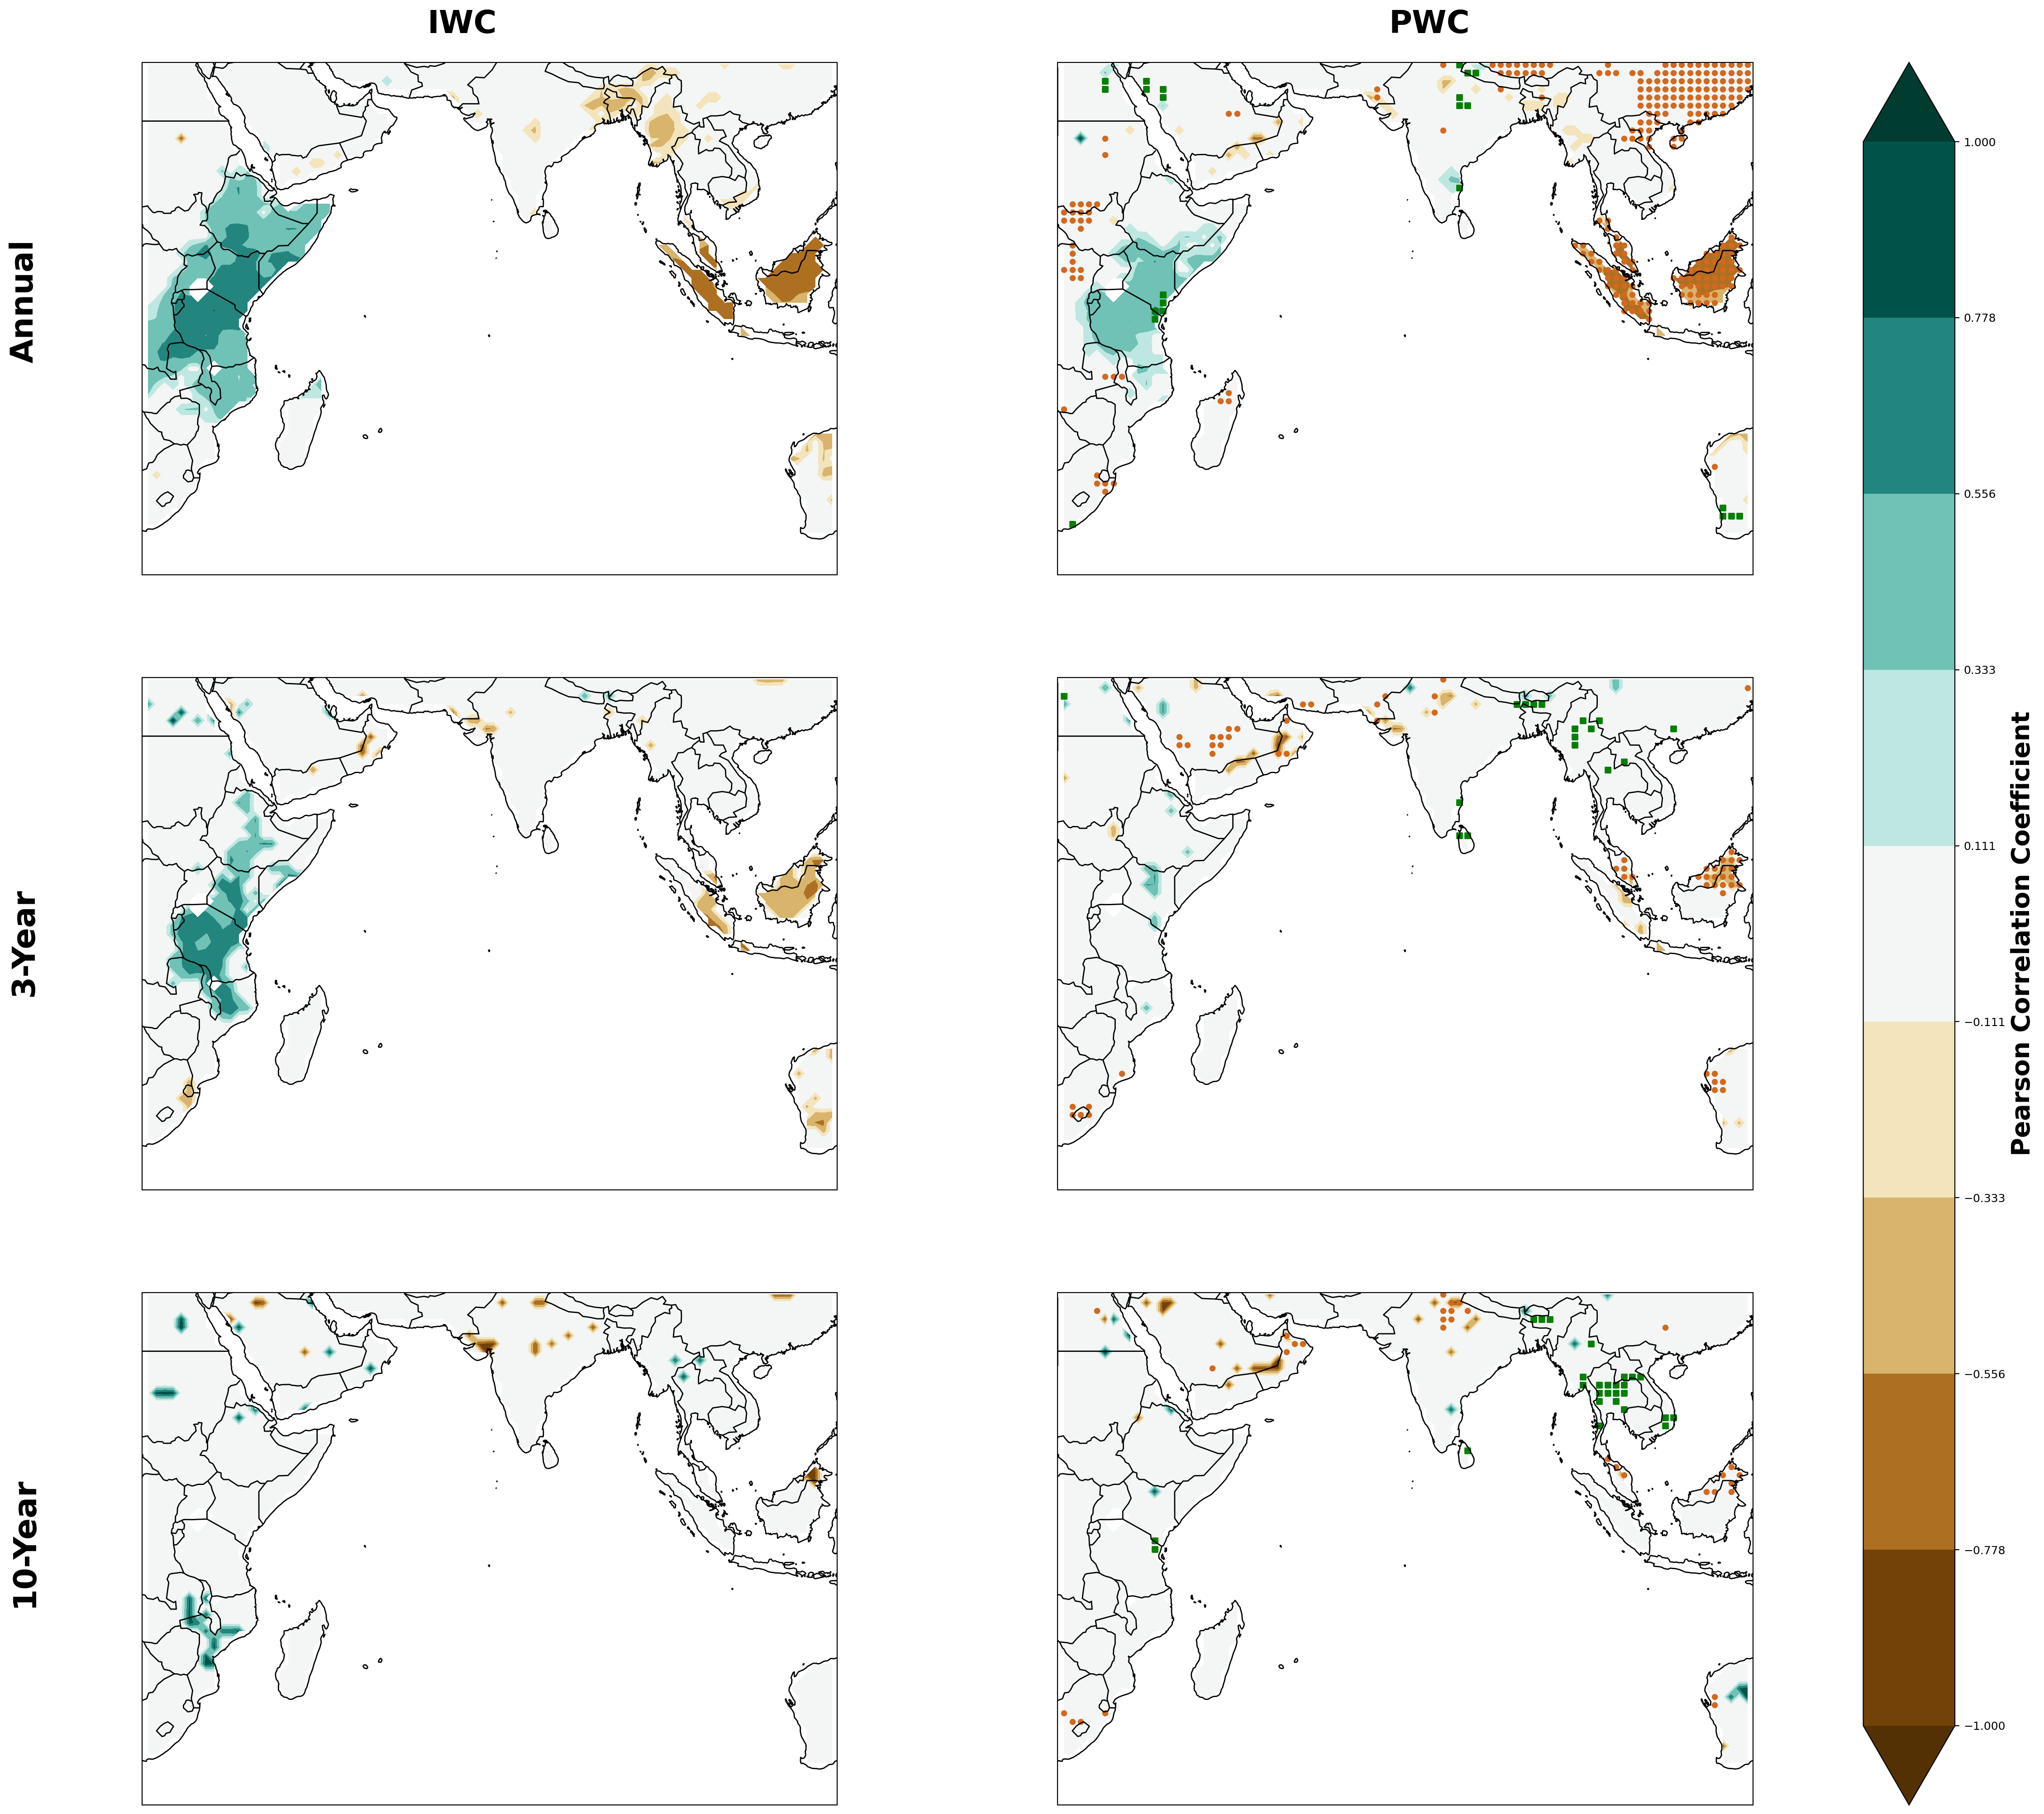

In [16]:
# Spatial Correlation with Colored Contours and IWC and PWC for each Column; Both Columns are OND
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1,1,1], width_ratios=[1,1,0.1], figure=fig)
gs.update(left=0.1, right=0.95, wspace=0, hspace=0.2)

levels = np.linspace(-1, 1, 10)
extent = [25, 120, -40, 30]

legend_elements = [Line2D([0], [0], color='black', linestyle='solid', linewidth=2, label='PWC Positive Correlation'),
                   Line2D([0], [0], color='black', linestyle='dashed', linewidth=2, label='PWC Negative Correlation')]

# IWC; OND Annual
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
cont1 = ax1.contourf(cor_mapOWSR.Longitude, cor_mapOWSR.Latitude, cor_mapOWSR.values, levels=levels, extend='both', cmap='BrBG')
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.BORDERS)

# PWC; OND Annual with solid for positive, dashed for negative
ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=0))
cont2 = ax2.contourf(cor_mapPWCSR.Longitude, cor_mapPWCSR.Latitude, cor_mapPWCSR.values, levels=levels, extend='both', cmap='BrBG')
significant_indices = np.where(cor_mapPWC.values < 0)  # Replace this with your significance condition
positive_indices = np.where(cor_mapPWC.values > 0)
ax2.scatter(cor_mapPWC.Longitude[positive_indices[1]], cor_mapPWC.Latitude[positive_indices[0]], 
            color='green', s=20, marker='s', label='Positive Correlation')
negative_indices = np.where(cor_mapPWC.values < 0)
ax2.scatter(cor_mapPWC.Longitude[negative_indices[1]], cor_mapPWC.Latitude[negative_indices[0]], 
            color='chocolate', s=15, marker='o', label='Negative Correlation')
ax2.set_extent(extent, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.BORDERS)

# IWC; OND 3-Year
ax3 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=0))
cont3 = ax3.contourf(cor_mapOW3o.Longitude, cor_mapOW3o.Latitude, cor_mapOW3o.values, levels=levels, extend='both', cmap='BrBG')
ax3.set_extent(extent, ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.BORDERS)

ax4 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=0))
cont4 = ax4.contourf(cor_mapPWC3o.Longitude, cor_mapPWC3o.Latitude, cor_mapPWC3o.values, levels=levels, extend='both', cmap='BrBG')
positive_indices3 = np.where(cor_mapPWC3.values > 0)
ax4.scatter(cor_mapPWC3.Longitude[positive_indices3[1]], cor_mapPWC3.Latitude[positive_indices3[0]], 
            color='green', s=20, marker='s', label='Positive Correlation')
negative_indices3 = np.where(cor_mapPWC3.values < 0)
ax4.scatter(cor_mapPWC3.Longitude[negative_indices3[1]], cor_mapPWC3.Latitude[negative_indices3[0]], 
            color='chocolate', s=15, marker='o', label='Negative Correlation')
ax4.set_extent(extent, ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax4.add_feature(cfeature.BORDERS)

# IWC; OND 10-Year
ax5 = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=0))
cont5 = ax5.contourf(cor_mapOW10o.Longitude, cor_mapOW10o.Latitude, cor_mapOW10o.values, levels=levels, extend='both', cmap='BrBG')
ax5.set_extent(extent, ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax5.add_feature(cfeature.BORDERS)

# PWC; OND 10-Year with solid for positive, dashed for negative
ax6 = fig.add_subplot(gs[2,1], projection=ccrs.PlateCarree(central_longitude=0))
cont6 = ax6.contourf(cor_mapPWC10o.Longitude, cor_mapPWC10o.Latitude, cor_mapPWC10o.values, levels=levels, extend='both', cmap='BrBG')
positive_indices10 = np.where(cor_mapPWC10.values > 0)
ax6.scatter(cor_mapPWC10.Longitude[positive_indices10[1]], cor_mapPWC10.Latitude[positive_indices10[0]], 
            color='green', s=20, marker='s', label='Positive Correlation')
negative_indices10 = np.where(cor_mapPWC10.values < 0)
ax6.scatter(cor_mapPWC10.Longitude[negative_indices10[1]], cor_mapPWC10.Latitude[negative_indices10[0]], 
            color='chocolate', s=15, marker='o', label='Negative Correlation')
ax6.set_extent(extent, ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax6.add_feature(cfeature.BORDERS)

# Adding annotations
fig.text(0.275, 0.893, 'IWC', fontsize=25, fontweight='bold', color='k')
fig.text(0.7, 0.893, 'PWC', fontsize=25, fontweight='bold', color='k')
fig.text(0.09, 0.75, 'Annual', fontsize=25, fontweight='bold', rotation=90, color='k')
fig.text(0.09, 0.47, '3-Year', fontsize=25, fontweight='bold', rotation=90, color='k')
fig.text(0.09, 0.2, '10-Year', fontsize=25, fontweight='bold', rotation=90, color='k')

# Adding color bar
ax7 = fig.add_subplot(gs[:,2])
cbar = plt.colorbar(cont1, cax=ax7, orientation='vertical') 
cbar.ax.tick_params(labelsize=9)
cbar.set_label('Pearson Correlation Coefficient', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.savefig('SaveYourOutput.pdf',bbox_inches='tight',dpi=300)

In [16]:
model = sm.OLS(y['Indo18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.552   
Dependent Variable: Indo18O          AIC:                158.0062
Date:               2024-08-14 10:13 BIC:                164.0823
No. Observations:   56               Log-Likelihood:     -76.003 
Df Model:           2                F-statistic:        34.83   
Df Residuals:       53               Prob (F-statistic): 2.20e-10
R-squared:          0.568            Scale:              0.93387 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -6.7269     0.1324   -50.8164   0.0000   -6.9925   -6.4614
u10      -0.4253     0.1175    -3.6180   0.0007   -0.6610   -0.1895
dSLPP    -0.4826     0.1583    -3.0490   0.0036   -0.8001   -0.1651
-----------------------------------------------------------------
Omnibus:       